In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/project_2_dataset.zip'

Archive:  /content/drive/MyDrive/project_2_dataset.zip
  inflating: train/A-D-08DIP-06B-SM.png  
  inflating: train/A-D-08DIP-06F-SM.png  
  inflating: train/A-D-08DIP-07B-SM.png  
  inflating: train/A-D-08DIP-07F-SM.png  
  inflating: train/A-D-08DIP-08B-SM.png  
  inflating: train/A-D-08DIP-08F-SM.png  
  inflating: train/A-D-08DIP-09B-SM.png  
  inflating: train/A-D-08DIP-09F-SM.png  
  inflating: train/A-D-08DIP-10B-SM.png  
  inflating: train/A-D-08DIP-10F-SM.png  
  inflating: train/A-D-16SOIC-06B-D.PNG  
  inflating: train/A-D-64QFP-17F-SM.png  
  inflating: train/A-D-64QFP-18B-SM.png  
  inflating: train/A-D-64QFP-18F-SM.png  
  inflating: train/A-D-64QFP-24B-D.png  
  inflating: train/A-D-64QFP-24F-D.png  
  inflating: train/A-D-64QFP-25B-D.png  
  inflating: train/A-D-64QFP-25F-D.png  
  inflating: train/A-D-64QFP-26B-D.png  
  inflating: train/A-D-64QFP-26F-D.png  
  inflating: train/A-D-64QFP-27B-D.png  
  inflating: train/A-D-64QFP-27F-D.png  
  inflating: train/A-D-64QFP-

In [4]:
directory = 'train'
target_size = (960, 720)
image_dataset = []

num_approved = 0
num_counterfiet = 0
for filename in os.listdir(directory):
    image_path = os.path.join(directory, filename)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    transform = transforms.Compose([transforms.ToTensor()])
    tensor = transform(image)
    if filename[0] == 'A':
        valid = 1
        num_approved = num_approved + 1
    else:
        valid = 0
        num_counterfiet = num_counterfiet + 1
    image_dataset.append((tensor, valid))

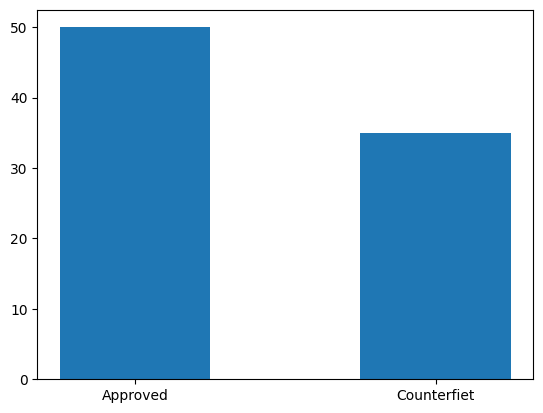

In [5]:
classes = [num_approved, num_counterfiet]
plt.bar(["Approved", "Counterfiet"], classes, width=0.5)
plt.show()

In [6]:
dataset_len = len(image_dataset)
train_len = int(0.8*dataset_len)
test_len = dataset_len - train_len

In [7]:
labels = [image[1] for image in image_dataset]

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=32)

train_idx, test_idx = next(splitter.split(np.zeros(len(labels)), labels))

In [8]:
len(train_idx), len(test_idx)

(68, 17)

In [9]:
transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

num_trainset = len(train_idx)
id = len(image_dataset)
i = 0; j = 0
while i < num_trainset:
    j = train_idx[i]
    image, label = image_dataset[j][0], image_dataset[j][1]
    num_loops = 5
    while num_loops > 0:
        pil_image = F.to_pil_image(image)
        transformed_img = transform(pil_image)
        image_dataset.append([transformed_img, label])
        # train_idx.append(id)
        train_idx = np.append(train_idx, id)
        id = id + 1
        num_loops = num_loops-1
    i = i + 1

In [10]:
trainset = torch.utils.data.Subset(image_dataset, train_idx)
testset = torch.utils.data.Subset(image_dataset, test_idx)
len(trainset), len(testset)

(408, 17)

In [11]:
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

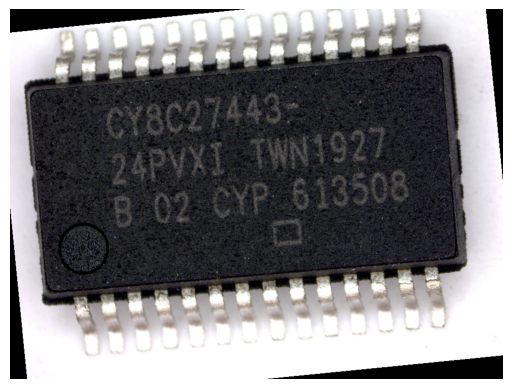

In [12]:
def display_image(image_tensor):

    image_np = image_tensor.numpy()
    image_np = np.transpose(image_np, (1, 2, 0))

    plt.imshow(image_np)
    plt.axis('off')
    plt.show()

display_image(trainset[-20][0])

In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

#### Function to train the model

In [14]:
def train_model(model, trainloader, testloader, num_epochs = 100, lr = 0.0002, patience = 5, min_delta = 0.05, save_model = False):

    epochs_without_improvement = 0
    best_val_loss = float('inf')

    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    train_losses = []
    train_acc_lst = []
    val_losses = []
    val_acc_lst = []

    for epoch in range(num_epochs):
        model.train()
        # load in the data in batches
        total_loss = 0
        correct = 0
        total = 0
        for images, labels in trainloader:
            # forward propagation
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_func(outputs, labels)

            total += labels.size(0)
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()

            # backward propagation and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        average_loss = total_loss / len(trainloader)
        train_acc = 100 * (correct / total)

        train_losses.append(average_loss)
        train_acc_lst.append(train_acc)
        # print('loss for epoch', epoch+1, average_loss)

        # at end of epoch check validation loss and acc
        with torch.no_grad():
            # switch model to eval (not train) model
            model.eval()
            correct = 0
            total = 0
            all_val_loss = []
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                total += labels.size(0)
                # calculate predictions
                predicted = torch.argmax(outputs, dim=1)
                # calculate actual values
                correct += (predicted == labels).sum().item()
                # calculate the loss
                all_val_loss.append(loss_func(outputs, labels).item())
            # calculate val-loss
            mean_val_loss = sum(all_val_loss) / len(all_val_loss)
            # calculate val-accuracy
            mean_val_acc = 100 * (correct / total)

            val_losses.append(mean_val_loss)
            val_acc_lst.append(mean_val_acc)

        print(
            'Epoch [{}/{}], Train-Loss: {:.4f}, Train-Acc: {:.1f}%, Val-Loss: {:.4f}, Val-Acc: {:.1f}%'.format(
                epoch+1, num_epochs, average_loss, train_acc, mean_val_loss, mean_val_acc
            )
        )

        if mean_val_loss < best_val_loss:
          best_val_loss = mean_val_loss
          epochs_without_improvement = 0
          # Save the best model
          # torch.save(model.state_dict(), 'best_model.pth')
          if save_model:
              torch.save(model,"/content/drive/MyDrive/cnn_model.pt")

        elif mean_val_loss - min_delta > best_val_loss:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping triggered.")
                break
    return train_losses, train_acc_lst, val_losses, val_acc_lst

#### Function to plot graph for loss & accuracy of train vs validation data

In [15]:
def plot_graph(train_loss, train_accuracy, validation_loss, validation_accuracy, model):
    epochs = range(1, len(train_accuracy) + 1)

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Train and Validation Accuracy
    axs[0].plot(epochs, train_accuracy, 'b', label='Train Accuracy')
    axs[0].plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
    axs[0].set_title('Train and Validation Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # Plot Train and Validation Loss
    axs[1].plot(epochs, train_loss, 'b', label='Train Loss')
    axs[1].plot(epochs, validation_loss, 'r', label='Validation Loss')
    axs[1].set_title('Train and Validation Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    fig.suptitle(model)

    # Adjust layout
    plt.tight_layout()
    plt.show()

### Alexnet model

In [16]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 2, dropout: float = 0.4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        self.float()
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [17]:
# Initialize the model and load into device
alexnet_model = AlexNet()
alexnet_model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Lin

Epoch [1/50], Train-Loss: 0.6902, Train-Acc: 56.4%, Val-Loss: 0.6944, Val-Acc: 58.8%
Epoch [2/50], Train-Loss: 0.6836, Train-Acc: 58.8%, Val-Loss: 0.6976, Val-Acc: 58.8%
Epoch [3/50], Train-Loss: 0.6803, Train-Acc: 58.8%, Val-Loss: 0.7007, Val-Acc: 58.8%
Epoch [4/50], Train-Loss: 0.6786, Train-Acc: 58.8%, Val-Loss: 0.7036, Val-Acc: 58.8%
Epoch [5/50], Train-Loss: 0.6780, Train-Acc: 58.8%, Val-Loss: 0.7057, Val-Acc: 58.8%
Epoch [6/50], Train-Loss: 0.6776, Train-Acc: 58.8%, Val-Loss: 0.7072, Val-Acc: 58.8%
Epoch [7/50], Train-Loss: 0.6772, Train-Acc: 58.8%, Val-Loss: 0.7079, Val-Acc: 58.8%
Epoch [8/50], Train-Loss: 0.6772, Train-Acc: 58.8%, Val-Loss: 0.7094, Val-Acc: 58.8%
Epoch [9/50], Train-Loss: 0.6769, Train-Acc: 58.8%, Val-Loss: 0.7100, Val-Acc: 58.8%
Epoch [10/50], Train-Loss: 0.6769, Train-Acc: 58.8%, Val-Loss: 0.7099, Val-Acc: 58.8%
Epoch [11/50], Train-Loss: 0.6767, Train-Acc: 58.8%, Val-Loss: 0.7106, Val-Acc: 58.8%
Epoch [12/50], Train-Loss: 0.6764, Train-Acc: 58.8%, Val-Loss: 

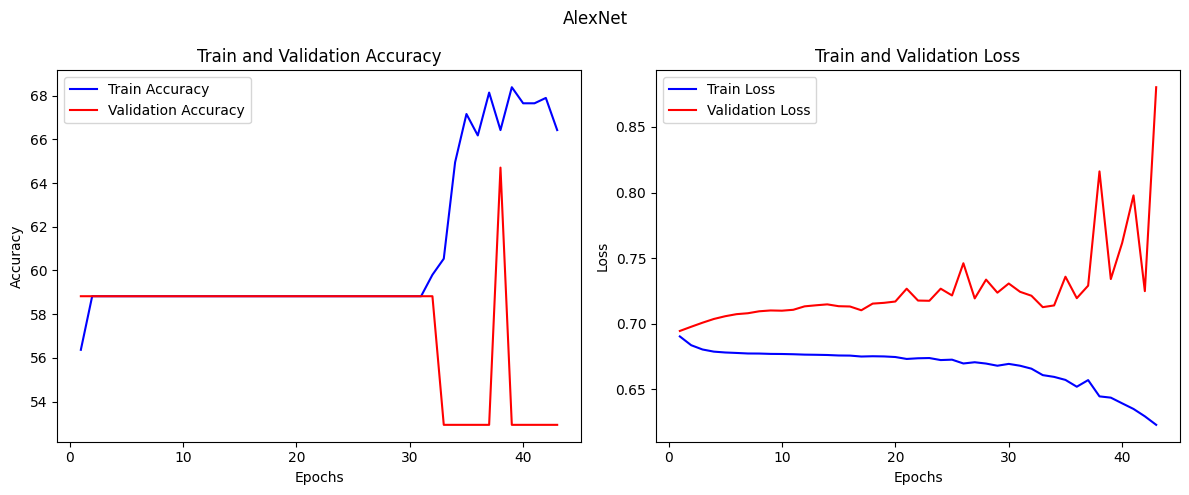

In [18]:
train_losses, train_acc_lst, val_losses, val_acc_lst = train_model(alexnet_model, trainloader, testloader, num_epochs = 50, lr = 0.005)
plot_graph(train_losses, train_acc_lst, val_losses, val_acc_lst, model = 'AlexNet')

### VGG16 model

In [19]:
import torchvision.models as models

# Load pre-trained VGG-16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze all the parameters in the network
for param in vgg16.parameters():
    param.requires_grad = False

# Modify the classifier to work for 2-class classification
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2)
)
vgg16 = vgg16.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:11<00:00, 48.2MB/s]


Epoch [1/50], Train-Loss: 0.6622, Train-Acc: 60.8%, Val-Loss: 0.6917, Val-Acc: 52.9%
Epoch [2/50], Train-Loss: 0.6179, Train-Acc: 67.6%, Val-Loss: 0.6963, Val-Acc: 52.9%
Epoch [3/50], Train-Loss: 0.5757, Train-Acc: 71.8%, Val-Loss: 0.7150, Val-Acc: 52.9%
Epoch [4/50], Train-Loss: 0.5217, Train-Acc: 76.0%, Val-Loss: 0.7179, Val-Acc: 70.6%
Epoch [5/50], Train-Loss: 0.5227, Train-Acc: 76.0%, Val-Loss: 0.7410, Val-Acc: 58.8%
Epoch [6/50], Train-Loss: 0.5024, Train-Acc: 78.2%, Val-Loss: 0.7553, Val-Acc: 70.6%
Epoch [7/50], Train-Loss: 0.4751, Train-Acc: 77.2%, Val-Loss: 0.7824, Val-Acc: 64.7%
Epoch [8/50], Train-Loss: 0.4519, Train-Acc: 80.6%, Val-Loss: 0.7835, Val-Acc: 70.6%
Epoch [9/50], Train-Loss: 0.4291, Train-Acc: 81.1%, Val-Loss: 0.8143, Val-Acc: 58.8%
Epoch [10/50], Train-Loss: 0.4180, Train-Acc: 81.9%, Val-Loss: 0.8228, Val-Acc: 70.6%
Early stopping triggered.


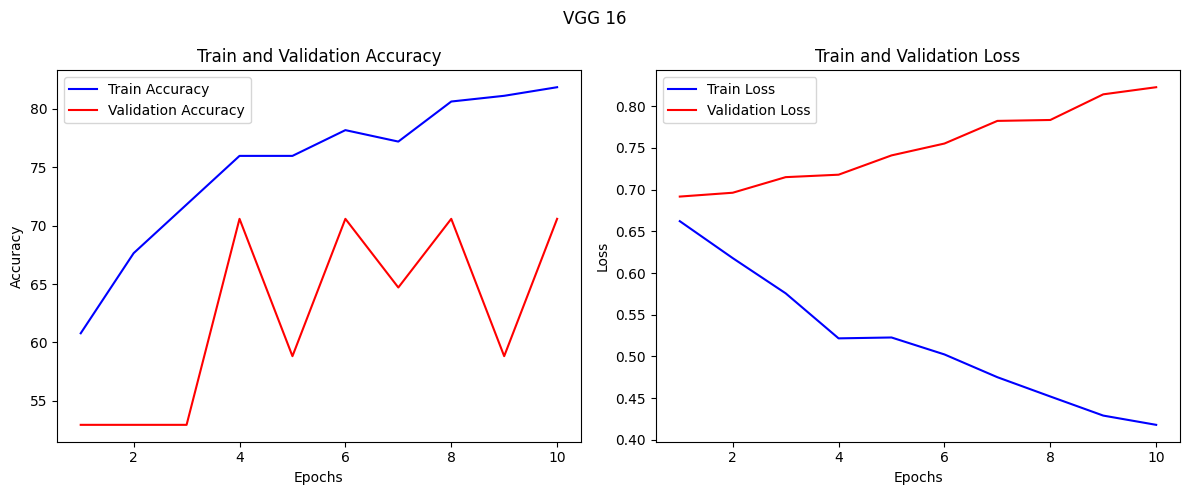

In [20]:
train_losses, train_acc_lst, val_losses, val_acc_lst = train_model(vgg16, trainloader, testloader, num_epochs = 50, lr = 0.005)
plot_graph(train_losses, train_acc_lst, val_losses, val_acc_lst, model = 'VGG 16')

### Custom CNN Model

In [21]:
class CNN(nn.Module):
    def __init__(self, kernel_size = 3, stride = 1):
        super().__init__()
        self.conv_layers = nn.Sequential(
            # Conv layer 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=kernel_size, padding=1, stride=stride),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Conv layer 2
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=kernel_size, padding=1, stride=stride),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Conv layer 3
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=kernel_size, padding=1, stride=stride),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Conv layer 4
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=kernel_size, padding=1, stride=stride),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Conv layer 5
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=kernel_size, padding=1, stride=stride),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Conv layer 6
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=kernel_size, padding=1, stride=stride),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Conv layer 7
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=kernel_size, padding=1, stride=stride),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=17920, out_features=2048),
            nn.Linear(in_features=2048, out_features=2048),
            nn.Linear(in_features=2048, out_features=1000),
            nn.Linear(in_features=1000, out_features=2)
        )

    def forward(self, x):
      x = self.conv_layers(x)
      x = self.flatten(x)
      out = self.fc_layers(x)
      return out

In [22]:
# Initialize the model and load into device
model = CNN()
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [23]:
# calulating number of paramters in the CNN model
num_params = 0
for x in model.parameters():
  num_params += len(torch.flatten(x))

print(f'Number of parameters in the model: {num_params:,}')

Number of parameters in the model: 44,526,698


In [24]:
for i, data in enumerate(trainloader):
    inputs, labels = data[0].to(device), data[1].to(device)
    print(f'input shape: {inputs.shape}')
    print(f'after network shape: {model(inputs).shape}')
    break

input shape: torch.Size([4, 3, 720, 960])
after network shape: torch.Size([4, 2])


Epoch [1/100], Train-Loss: 0.6709, Train-Acc: 61.8%, Val-Loss: 0.5970, Val-Acc: 70.6%
Epoch [2/100], Train-Loss: 0.6452, Train-Acc: 64.0%, Val-Loss: 0.5453, Val-Acc: 70.6%
Epoch [3/100], Train-Loss: 0.6299, Train-Acc: 67.6%, Val-Loss: 0.5408, Val-Acc: 70.6%
Epoch [4/100], Train-Loss: 0.6106, Train-Acc: 70.6%, Val-Loss: 0.5372, Val-Acc: 70.6%
Epoch [5/100], Train-Loss: 0.5910, Train-Acc: 71.6%, Val-Loss: 0.5340, Val-Acc: 70.6%
Epoch [6/100], Train-Loss: 0.5816, Train-Acc: 72.3%, Val-Loss: 0.5483, Val-Acc: 76.5%
Epoch [7/100], Train-Loss: 0.5754, Train-Acc: 75.2%, Val-Loss: 0.5362, Val-Acc: 64.7%
Epoch [8/100], Train-Loss: 0.5542, Train-Acc: 74.8%, Val-Loss: 0.5489, Val-Acc: 76.5%
Epoch [9/100], Train-Loss: 0.5398, Train-Acc: 75.2%, Val-Loss: 0.5415, Val-Acc: 64.7%
Epoch [10/100], Train-Loss: 0.5355, Train-Acc: 75.5%, Val-Loss: 0.5557, Val-Acc: 76.5%
Epoch [11/100], Train-Loss: 0.5285, Train-Acc: 75.5%, Val-Loss: 0.5798, Val-Acc: 82.4%
Epoch [12/100], Train-Loss: 0.5218, Train-Acc: 77.0%

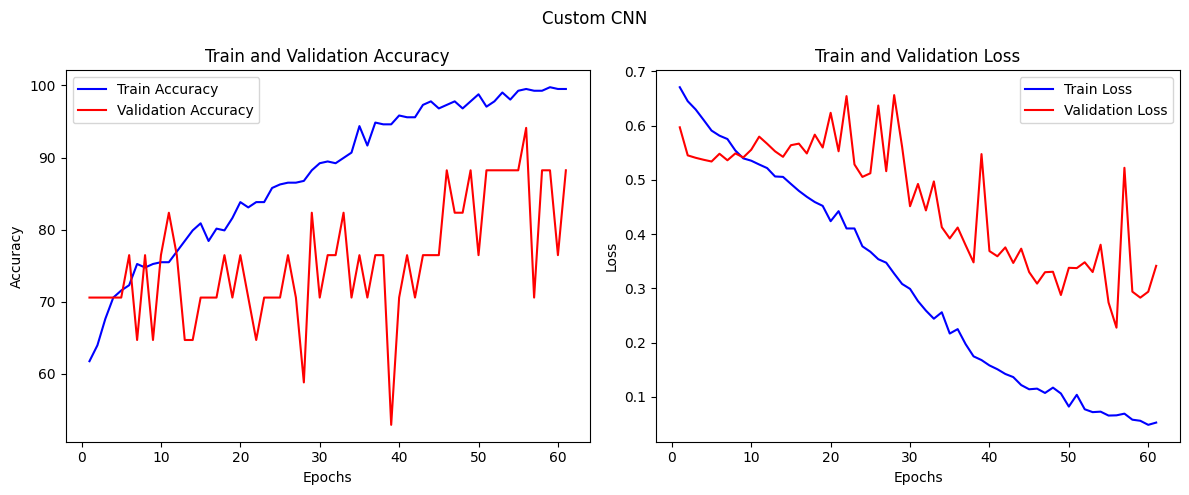

In [25]:
train_losses, train_acc_lst, val_losses, val_acc_lst = train_model(model, trainloader, testloader, save_model = True)
plot_graph(train_losses, train_acc_lst, val_losses, val_acc_lst, model = "Custom CNN")

### Loading the saved model which have the least validation loss

In [26]:
loaded_model = torch.load("/content/drive/MyDrive/cnn_model.pt")

actual_labels = []
predicted_labels = []
with torch.no_grad():
    loaded_model.eval()
    correct = 0
    total = 0
    all_val_loss = []
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = loaded_model(images)
        predicted = torch.argmax(outputs, dim=1)
        actual_labels = actual_labels + [label.item() for label in labels]
        predicted_labels = predicted_labels + [label.item() for label in predicted]

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_confusion_matrix_plot(actual_labels, predicted_labels):
    # Create the confusion matrix
    cm = confusion_matrix(actual_labels, predicted_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    tn, fp, fn, tp = confusion_matrix(actual_labels, predicted_labels, labels=[0, 1]).ravel()
    print("Positive - Approved, Negative - Counterfiet")
    print("True Negative:", tn)
    print("False Positive:", fp)
    print("False Negative:", fn)
    print("True Positive:", tp)

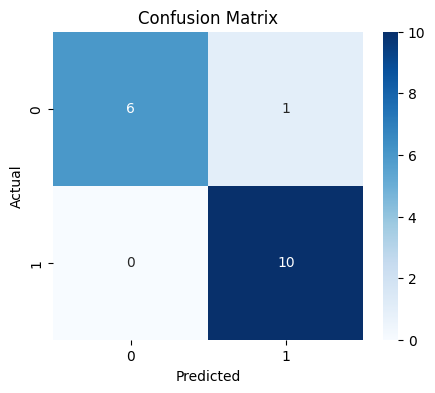

Positive - Approved, Negative - Counterfiet
True Negative: 6
False Positive: 1
False Negative: 0
True Positive: 10


In [28]:
get_confusion_matrix_plot(actual_labels, predicted_labels)

In [29]:
from sklearn.metrics import classification_report
print(classification_report(actual_labels, predicted_labels))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.91      1.00      0.95        10

    accuracy                           0.94        17
   macro avg       0.95      0.93      0.94        17
weighted avg       0.95      0.94      0.94        17



### Function to get the model outputs for the test set

In [ ]:
def get_img_tensor(image_path, target_size = (960, 720)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    transform = transforms.Compose([transforms.ToTensor()])
    tensor = transform(image)
    return tensor

def get_test_dataloader(test_directory):
    test_img_tensors = []
    for filename in os.listdir(test_directory):
        image_path = os.path.join(directory, filename)
        tensor = get_img_tensor(image_path)
        if filename[0] == 'A':
            valid = 1
        else:
            valid = 0
        test_img_tensors.append((tensor, valid))

    test_dataset = torch.utils.data.Subset(test_img_tensors, list(range(0, len(test_img_tensors))))
    # test_dataset = torch.utils.data.TensorDataset(*test_img_tensors)
    test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_data_loader

def get_test_output(test_directory):
    test_data_loader = get_test_dataloader(test_directory)
    actual_labels = []
    predicted_labels = []
    with torch.no_grad():
        loaded_model.eval()
        for images, labels in test_data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = loaded_model(images)
            predicted = torch.argmax(outputs, dim=1)
            actual_labels = actual_labels + [label.item() for label in labels]
            predicted_labels = predicted_labels + [label.item() for label in predicted]
    print(classification_report(actual_labels, predicted_labels))
    return actual_labels, predicted_labels

In [ ]:
# Give the test path here
test_path = "./test"
actual_labels, predicted_labels = get_test_output(test_path)

In [ ]:
get_confusion_matrix_plot(actual_labels, predicted_labels)